In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import funcs
import jan
import coral
import star
import mcd
import dann
import base
import plots
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load testbed data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "/home/ash/ic3/testbed_da/data"

# Classes - all different const. number
class_subset = ["bpsk", "qpsk", "4qam", "16qam", "apsk"]

# Split source, target
# try selecting some of the mods, not all
X = np.load(file_path + "/SNR_X.npy") # tmpSNR_ does not include 4qam. SNR_ does.
Y = np.load(file_path + "/SNR_Y.npy")

doppler_offset_source = 24
doppler_offset_target = 10

base_acc = []
dann_acc = []
star_acc = []
mcd_acc = []
coral_acc = []
jan_acc = []

for i in range(7):    
    source_mask = (Y[:, 1] == doppler_offset_source)
    target_mask = (Y[:, 1] == doppler_offset_target)
    
    X_s = X[source_mask]
    Y_s = Y[source_mask]
    Y_s = Y_s[:,0]
    
    X_t = X[target_mask]
    Y_t = Y[target_mask]
    Y_t = Y_t[:,0]

    
    # Dataloaders
    S_train_loader, S_val_loader = funcs.create_loader(X_s, Y_s, permute=False)
    T_train_loader, T_val_loader = funcs.create_loader(X_t, Y_t, permute=False)

    _, t_base = base.Base(model_cls=base.CLDNN, device=device, S_train_loader=S_train_loader, 
                    S_val_loader=S_val_loader, T_val_loader=T_val_loader, class_subset=class_subset, 
                    n_classes=len(class_subset), lr=0.001, n_epochs=50, n_runs=10).run()
    torch.cuda.empty_cache()
    base_acc.append(t_base)
    
    _, t_dan = dann.DAN(dann.DANN, FA=dann.CLDNN_FA, LP=dann.CLDNN_LP, DC=dann.CLDNN_DC,
                      device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,
                      T_train_loader=T_train_loader, T_val_loader=T_val_loader,
                      class_subset=class_subset, n_classes=len(class_subset), lr=0.001,
                      n_epochs=25, n_runs=10).run()
    torch.cuda.empty_cache()
    dann_acc.append(t_dan)
    
    _, t_star = star.Star(G=star.CLDNN_G, C=star.CLDNN_C, device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,  
               T_train_loader=T_train_loader, T_val_loader=T_val_loader, class_subset=class_subset,
               n_classes=len(class_subset), lr=0.001, n_epochs=50, n_runs=10, patience=5).run()
    torch.cuda.empty_cache()
    star_acc.append(t_star)
    
    _, t_mcd = mcd.Mcd(G=mcd.CLDNN_G, C=mcd.CLDNN_C, device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,  
               T_train_loader=T_train_loader, T_val_loader=T_val_loader, class_subset=class_subset,
               n_classes=len(class_subset), lr=0.001, n_epochs=50, n_runs=10, patience=5).run()
    torch.cuda.empty_cache()
    mcd_acc.append(t_mcd)
    
    _, t_coral = coral.Coral(G=coral.CLDNN_G, C=coral.CLDNN_C, device=device, S_train_loader=S_train_loader,
                           S_val_loader=S_val_loader, T_train_loader=T_train_loader, T_val_loader=T_val_loader,
                           class_subset=class_subset, n_classes=len(class_subset), lr=0.001, n_epochs=50, n_runs=10,
                           patience=5, lambda_coral=1).run()
    torch.cuda.empty_cache()
    coral_acc.append(t_coral)

    _, t_jan = jan.Jan(num_classes=len(class_subset), device=device, S_train_loader=S_train_loader,
                     T_train_loader=T_train_loader, S_val_loader=S_val_loader, T_val_loader=T_val_loader,
                     n_epochs=50, lr=0.001, lambda_jmmd=0.1, n_runs=10).run()
    torch.cuda.empty_cache()
    jan_acc.append(t_jan)
    
    doppler_offset_target += 2


Run 1/10
Epoch 1/50, Train Loss: 1.4118, Train Acc: 0.3700, Val Loss: 0.9550, Val Acc: 0.4055
Epoch 2/50, Train Loss: 0.7938, Train Acc: 0.5429, Val Loss: 0.4011, Val Acc: 0.8030
Epoch 3/50, Train Loss: 0.6790, Train Acc: 0.6645, Val Loss: 1.4440, Val Acc: 0.4197
Epoch 4/50, Train Loss: 0.7248, Train Acc: 0.7672, Val Loss: 0.1255, Val Acc: 0.9983
Epoch 5/50, Train Loss: 0.3259, Train Acc: 0.8521, Val Loss: 0.0041, Val Acc: 0.9993
Epoch 6/50, Train Loss: 0.3953, Train Acc: 0.9131, Val Loss: 3.6859, Val Acc: 0.5879
Epoch 7/50, Train Loss: 0.3824, Train Acc: 0.9117, Val Loss: 0.0754, Val Acc: 0.9944
Epoch 8/50, Train Loss: 0.7474, Train Acc: 0.8792, Val Loss: 0.1511, Val Acc: 0.9902
Epoch 9/50, Train Loss: 0.7848, Train Acc: 0.7921, Val Loss: 0.2853, Val Acc: 0.7979
Epoch 10/50, Train Loss: 0.2486, Train Acc: 0.9544, Val Loss: 0.0025, Val Acc: 0.9993
Epoch 11/50, Train Loss: 0.0071, Train Acc: 0.9991, Val Loss: 0.0014, Val Acc: 0.9998
Epoch 12/50, Train Loss: 0.0054, Train Acc: 0.9995, V

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.3816, Train Acc: 0.3652, Val Loss: 1.9513, Val Acc: 0.4119
Epoch 2/50, Train Loss: 0.9730, Train Acc: 0.5665, Val Loss: 0.9555, Val Acc: 0.4121
Epoch 3/50, Train Loss: 0.6160, Train Acc: 0.7113, Val Loss: 1.3131, Val Acc: 0.6287
Epoch 4/50, Train Loss: 0.6198, Train Acc: 0.8009, Val Loss: 0.7474, Val Acc: 0.8049
Epoch 5/50, Train Loss: 0.6399, Train Acc: 0.8246, Val Loss: 0.1652, Val Acc: 0.8752
Epoch 6/50, Train Loss: 0.6622, Train Acc: 0.8735, Val Loss: 0.0070, Val Acc: 0.9995
Epoch 7/50, Train Loss: 0.4134, Train Acc: 0.9230, Val Loss: 0.6566, Val Acc: 0.7988
Epoch 8/50, Train Loss: 0.5161, Train Acc: 0.8912, Val Loss: 0.2428, Val Acc: 0.8328
Epoch 9/50, Train Loss: 0.4873, Train Acc: 0.9155, Val Loss: 0.0037, Val Acc: 0.9995
Epoch 10/50, Train Loss: 0.4291, Train Acc: 0.9146, Val Loss: 0.4737, Val Acc: 0.8069
Epoch 11/50, Train Loss: 0.0174, Train Acc: 0.9943, Val Loss: 0.0008, Val Acc: 0.9998
Epoch 12/50, Train Loss: 0.0075, Train Acc: 0.9995, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1560, Domain Loss: 1.4525, Class Loss: 1.7035
Epoch 2/25, Loss: 3.0240, Domain Loss: 1.3881, Class Loss: 1.6359
Epoch 3/25, Loss: 2.9242, Domain Loss: 1.3799, Class Loss: 1.5443
Epoch 4/25, Loss: 2.5161, Domain Loss: 1.4212, Class Loss: 1.0950
Epoch 5/25, Loss: 2.2291, Domain Loss: 1.3144, Class Loss: 0.9148
Epoch 6/25, Loss: 2.0102, Domain Loss: 1.2206, Class Loss: 0.7896
Epoch 7/25, Loss: 1.5417, Domain Loss: 1.1802, Class Loss: 0.3615
Epoch 8/25, Loss: 1.7633, Domain Loss: 1.1866, Class Loss: 0.5767
Epoch 9/25, Loss: 1.4220, Domain Loss: 1.1640, Class Loss: 0.2580
Epoch 10/25, Loss: 1.3037, Domain Loss: 1.1604, Class Loss: 0.1433
Epoch 11/25, Loss: 2.0192, Domain Loss: 1.2048, Class Loss: 0.8144
Epoch 12/25, Loss: 1.5739, Domain Loss: 1.2035, Class Loss: 0.3704
Epoch 13/25, Loss: 1.3146, Domain Loss: 1.1774, Class Loss: 0.1372
Epoch 14/25, Loss: 2.2001, Domain Loss: 1.2076, Class Loss: 0.9925
Epoch 15/25, Loss: 1.5747, Domain Loss: 1.1995, Class Loss: 0.3752
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1405, Domain Loss: 1.4265, Class Loss: 1.7140
Epoch 2/25, Loss: 3.2106, Domain Loss: 1.6524, Class Loss: 1.5582
Epoch 3/25, Loss: 3.3275, Domain Loss: 1.7296, Class Loss: 1.5979
Epoch 4/25, Loss: 2.3118, Domain Loss: 1.3768, Class Loss: 0.9350
Epoch 5/25, Loss: 2.2638, Domain Loss: 1.3797, Class Loss: 0.8841
Epoch 6/25, Loss: 1.7194, Domain Loss: 1.3248, Class Loss: 0.3946
Epoch 7/25, Loss: 2.0321, Domain Loss: 1.2825, Class Loss: 0.7496
Epoch 8/25, Loss: 1.5728, Domain Loss: 1.2371, Class Loss: 0.3357
Epoch 9/25, Loss: 1.3500, Domain Loss: 1.1729, Class Loss: 0.1771
Epoch 10/25, Loss: 1.3622, Domain Loss: 1.1715, Class Loss: 0.1907
Epoch 11/25, Loss: 1.8682, Domain Loss: 1.1721, Class Loss: 0.6961
Epoch 12/25, Loss: 1.5135, Domain Loss: 1.1724, Class Loss: 0.3411
Epoch 13/25, Loss: 1.3464, Domain Loss: 1.1699, Class Loss: 0.1765
Epoch 14/25, Loss: 1.3542, Domain Loss: 1.1728, Class Loss: 0.1814
Epoch 15/25, Loss: 1.4637, Domain Loss: 1.1640, Class Loss: 0.2998
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1535, Domain Loss: 1.4279, Class Loss: 1.7256
Epoch 2/25, Loss: 3.0206, Domain Loss: 1.3866, Class Loss: 1.6340
Epoch 3/25, Loss: 2.9890, Domain Loss: 1.4098, Class Loss: 1.5792
Epoch 4/25, Loss: 2.9264, Domain Loss: 1.4755, Class Loss: 1.4510
Epoch 5/25, Loss: 2.3338, Domain Loss: 1.3767, Class Loss: 0.9570
Epoch 6/25, Loss: 2.4343, Domain Loss: 1.3514, Class Loss: 1.0829
Epoch 7/25, Loss: 2.0146, Domain Loss: 1.3397, Class Loss: 0.6749
Epoch 8/25, Loss: 1.8266, Domain Loss: 1.2633, Class Loss: 0.5632
Epoch 9/25, Loss: 1.4944, Domain Loss: 1.1832, Class Loss: 0.3112
Epoch 10/25, Loss: 1.4955, Domain Loss: 1.1744, Class Loss: 0.3211
Epoch 11/25, Loss: 1.4307, Domain Loss: 1.1653, Class Loss: 0.2654
Epoch 12/25, Loss: 1.3327, Domain Loss: 1.1634, Class Loss: 0.1693
Epoch 13/25, Loss: 1.4771, Domain Loss: 1.1678, Class Loss: 0.3092
Epoch 14/25, Loss: 1.2871, Domain Loss: 1.1510, Class Loss: 0.1360
Epoch 15/25, Loss: 1.3769, Domain Loss: 1.1711, Class Loss: 0.2058
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1303, Domain Loss: 1.4212, Class Loss: 1.7091
Epoch 2/25, Loss: 2.9968, Domain Loss: 1.3885, Class Loss: 1.6083
Epoch 3/25, Loss: 2.4152, Domain Loss: 1.3102, Class Loss: 1.1051
Epoch 4/25, Loss: 2.1878, Domain Loss: 1.2691, Class Loss: 0.9187
Epoch 5/25, Loss: 1.8837, Domain Loss: 1.2501, Class Loss: 0.6336
Epoch 6/25, Loss: 1.5729, Domain Loss: 1.2314, Class Loss: 0.3415
Epoch 7/25, Loss: 2.5913, Domain Loss: 1.2934, Class Loss: 1.2979
Epoch 8/25, Loss: 1.7875, Domain Loss: 1.2375, Class Loss: 0.5500
Epoch 9/25, Loss: 1.5160, Domain Loss: 1.2335, Class Loss: 0.2825
Epoch 10/25, Loss: 1.5010, Domain Loss: 1.1752, Class Loss: 0.3258
Epoch 11/25, Loss: 1.3261, Domain Loss: 1.1519, Class Loss: 0.1742
Epoch 12/25, Loss: 1.2495, Domain Loss: 1.1308, Class Loss: 0.1187
Epoch 13/25, Loss: 2.2177, Domain Loss: 1.1797, Class Loss: 1.0380
Epoch 14/25, Loss: 1.4183, Domain Loss: 1.1470, Class Loss: 0.2713
Epoch 15/25, Loss: 1.3263, Domain Loss: 1.1376, Class Loss: 0.1887
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1220, Domain Loss: 1.4189, Class Loss: 1.7030
Epoch 2/25, Loss: 2.7645, Domain Loss: 1.3669, Class Loss: 1.3975
Epoch 3/25, Loss: 2.3122, Domain Loss: 1.2807, Class Loss: 1.0315
Epoch 4/25, Loss: 2.6055, Domain Loss: 1.4383, Class Loss: 1.1672
Epoch 5/25, Loss: 2.1384, Domain Loss: 1.2930, Class Loss: 0.8454
Epoch 6/25, Loss: 1.7227, Domain Loss: 1.1898, Class Loss: 0.5329
Epoch 7/25, Loss: 2.3934, Domain Loss: 1.2147, Class Loss: 1.1786
Epoch 8/25, Loss: 1.9435, Domain Loss: 1.2006, Class Loss: 0.7429
Epoch 9/25, Loss: 1.5110, Domain Loss: 1.1646, Class Loss: 0.3464
Epoch 10/25, Loss: 1.4572, Domain Loss: 1.1611, Class Loss: 0.2961
Epoch 11/25, Loss: 1.4799, Domain Loss: 1.1633, Class Loss: 0.3166
Epoch 12/25, Loss: 1.4221, Domain Loss: 1.1585, Class Loss: 0.2636
Epoch 13/25, Loss: 1.3767, Domain Loss: 1.1511, Class Loss: 0.2256
Epoch 14/25, Loss: 1.2252, Domain Loss: 1.1356, Class Loss: 0.0897
Epoch 15/25, Loss: 3.0496, Domain Loss: 1.2341, Class Loss: 1.8156
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1245, Domain Loss: 1.4161, Class Loss: 1.7084
Epoch 2/25, Loss: 2.7204, Domain Loss: 1.3755, Class Loss: 1.3448
Epoch 3/25, Loss: 2.5634, Domain Loss: 1.3674, Class Loss: 1.1960
Epoch 4/25, Loss: 2.2705, Domain Loss: 1.2610, Class Loss: 1.0095
Epoch 5/25, Loss: 1.8387, Domain Loss: 1.2101, Class Loss: 0.6286
Epoch 6/25, Loss: 1.6144, Domain Loss: 1.1560, Class Loss: 0.4584
Epoch 7/25, Loss: 1.4204, Domain Loss: 1.1725, Class Loss: 0.2479
Epoch 8/25, Loss: 1.4118, Domain Loss: 1.1640, Class Loss: 0.2479
Epoch 9/25, Loss: 1.4031, Domain Loss: 1.1678, Class Loss: 0.2353
Epoch 10/25, Loss: 1.8791, Domain Loss: 1.1774, Class Loss: 0.7017
Epoch 11/25, Loss: 1.3981, Domain Loss: 1.1630, Class Loss: 0.2351
Epoch 12/25, Loss: 1.2656, Domain Loss: 1.1659, Class Loss: 0.0997
Epoch 13/25, Loss: 1.8785, Domain Loss: 1.1849, Class Loss: 0.6936
Epoch 14/25, Loss: 1.4411, Domain Loss: 1.1374, Class Loss: 0.3036
Epoch 15/25, Loss: 1.3143, Domain Loss: 1.1300, Class Loss: 0.1842
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.2677, Train Acc: 0.4179, Val Loss: 0.6894, Val Acc: 0.5403
Epoch 2/50, Train Loss: 1.2074, Train Acc: 0.6336, Val Loss: 1.0299, Val Acc: 0.5762
Epoch 3/50, Train Loss: 1.0436, Train Acc: 0.5939, Val Loss: 0.2384, Val Acc: 0.8088
Epoch 4/50, Train Loss: 0.5862, Train Acc: 0.8164, Val Loss: 0.4516, Val Acc: 0.8025
Epoch 5/50, Train Loss: 0.3659, Train Acc: 0.8714, Val Loss: 0.0187, Val Acc: 0.9990
Epoch 6/50, Train Loss: 0.2102, Train Acc: 0.9221, Val Loss: 0.0093, Val Acc: 0.9993
Epoch 7/50, Train Loss: 0.1598, Train Acc: 0.9512, Val Loss: 0.0138, Val Acc: 0.9988
Epoch 8/50, Train Loss: 0.7514, Train Acc: 0.8094, Val Loss: 0.0787, Val Acc: 0.9983
Epoch 9/50, Train Loss: 0.5698, Train Acc: 0.8464, Val Loss: 2.7955, Val Acc: 0.4739
Epoch 10/50, Train Loss: 0.6591, Train Acc: 0.8895, Val Loss: 0.0058, Val Acc: 0.9998
Epoch 11/50, Train Loss: 0.0042, Train Acc: 0.9993, Val Loss: 0.0052, Val Acc: 0.9998
Epoch 12/50, Train Loss: 0.0044, Train Acc: 0.9993, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.3898, Train Acc: 0.3945, Val Loss: 0.5038, Val Acc: 0.7961
Epoch 2/50, Train Loss: 0.6145, Train Acc: 0.6607, Val Loss: 0.8370, Val Acc: 0.4614
Epoch 3/50, Train Loss: 0.9089, Train Acc: 0.6672, Val Loss: 0.2233, Val Acc: 0.9983
Epoch 4/50, Train Loss: 0.3683, Train Acc: 0.8303, Val Loss: 0.3600, Val Acc: 0.7693
Epoch 5/50, Train Loss: 0.4831, Train Acc: 0.7872, Val Loss: 0.1434, Val Acc: 0.9060
Epoch 6/50, Train Loss: 0.3737, Train Acc: 0.8761, Val Loss: 0.1778, Val Acc: 0.8999
Epoch 7/50, Train Loss: 0.5998, Train Acc: 0.8204, Val Loss: 1.8892, Val Acc: 0.4072
Epoch 8/50, Train Loss: 0.5500, Train Acc: 0.8536, Val Loss: 1.0648, Val Acc: 0.8044
Epoch 9/50, Train Loss: 0.4349, Train Acc: 0.9083, Val Loss: 0.7834, Val Acc: 0.8027
Epoch 10/50, Train Loss: 0.4430, Train Acc: 0.9216, Val Loss: 0.0286, Val Acc: 0.9990
Epoch 11/50, Train Loss: 0.0087, Train Acc: 0.9993, Val Loss: 0.0013, Val Acc: 0.9998
Epoch 12/50, Train Loss: 0.0073, Train Acc: 0.9993, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.5508, Train Acc: 0.3812, Val Loss: 0.7261, Val Acc: 0.4878
Epoch 2/50, Train Loss: 0.6423, Train Acc: 0.6352, Val Loss: 0.3348, Val Acc: 0.7942
Epoch 3/50, Train Loss: 0.8367, Train Acc: 0.7377, Val Loss: 1.0228, Val Acc: 0.5312
Epoch 4/50, Train Loss: 0.4441, Train Acc: 0.7747, Val Loss: 3.6701, Val Acc: 0.4004
Epoch 5/50, Train Loss: 1.1035, Train Acc: 0.5923, Val Loss: 0.4431, Val Acc: 0.7795
Epoch 6/50, Train Loss: 0.4750, Train Acc: 0.7910, Val Loss: 0.0447, Val Acc: 0.9988
Epoch 7/50, Train Loss: 0.6913, Train Acc: 0.8195, Val Loss: 0.0439, Val Acc: 0.9995
Epoch 8/50, Train Loss: 0.5961, Train Acc: 0.8871, Val Loss: 0.6456, Val Acc: 0.8027
Epoch 9/50, Train Loss: 0.4372, Train Acc: 0.8787, Val Loss: 0.0297, Val Acc: 0.9990
Epoch 10/50, Train Loss: 0.5020, Train Acc: 0.8696, Val Loss: 0.2043, Val Acc: 0.8618
Epoch 11/50, Train Loss: 0.0149, Train Acc: 0.9968, Val Loss: 0.0051, Val Acc: 0.9995
Epoch 12/50, Train Loss: 0.0087, Train Acc: 0.9994, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.3119, Train Acc: 0.3895, Val Loss: 0.5551, Val Acc: 0.6743
Epoch 2/50, Train Loss: 0.5393, Train Acc: 0.6914, Val Loss: 0.5623, Val Acc: 0.7366
Epoch 3/50, Train Loss: 0.6872, Train Acc: 0.7469, Val Loss: 1.8285, Val Acc: 0.5991
Epoch 4/50, Train Loss: 0.8273, Train Acc: 0.6979, Val Loss: 0.3120, Val Acc: 0.8047
Epoch 5/50, Train Loss: 0.6668, Train Acc: 0.8133, Val Loss: 0.0857, Val Acc: 0.9988
Epoch 6/50, Train Loss: 0.4453, Train Acc: 0.8523, Val Loss: 0.1839, Val Acc: 0.8027
Epoch 7/50, Train Loss: 0.2465, Train Acc: 0.8804, Val Loss: 0.4087, Val Acc: 0.8020
Epoch 8/50, Train Loss: 0.5444, Train Acc: 0.8089, Val Loss: 0.2081, Val Acc: 0.8022
Epoch 9/50, Train Loss: 0.4973, Train Acc: 0.8717, Val Loss: 2.2716, Val Acc: 0.7581
Epoch 10/50, Train Loss: 0.4456, Train Acc: 0.9138, Val Loss: 0.0019, Val Acc: 0.9993
Epoch 11/50, Train Loss: 0.0089, Train Acc: 0.9992, Val Loss: 0.0014, Val Acc: 0.9998
Epoch 12/50, Train Loss: 0.0072, Train Acc: 0.9993, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.2452, Train Acc: 0.3904, Val Loss: 0.6214, Val Acc: 0.6018
Epoch 2/50, Train Loss: 0.5618, Train Acc: 0.6635, Val Loss: 0.3428, Val Acc: 0.7886
Epoch 3/50, Train Loss: 1.3034, Train Acc: 0.6694, Val Loss: 0.7926, Val Acc: 0.7495
Epoch 4/50, Train Loss: 0.7400, Train Acc: 0.7162, Val Loss: 0.4578, Val Acc: 0.8044
Epoch 5/50, Train Loss: 0.7192, Train Acc: 0.8747, Val Loss: 0.1929, Val Acc: 0.8975
Epoch 6/50, Train Loss: 0.2937, Train Acc: 0.9377, Val Loss: 0.0308, Val Acc: 0.9990
Epoch 7/50, Train Loss: 1.0078, Train Acc: 0.8259, Val Loss: 0.1251, Val Acc: 0.9985
Epoch 8/50, Train Loss: 0.0634, Train Acc: 0.9896, Val Loss: 0.0099, Val Acc: 0.9978
Epoch 9/50, Train Loss: 0.6682, Train Acc: 0.8312, Val Loss: 0.7360, Val Acc: 0.7959
Epoch 10/50, Train Loss: 0.5247, Train Acc: 0.8911, Val Loss: 0.3309, Val Acc: 0.8020
Epoch 11/50, Train Loss: 0.0103, Train Acc: 0.9962, Val Loss: 0.0031, Val Acc: 0.9995
Epoch 12/50, Train Loss: 0.0026, Train Acc: 0.9996, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.5199, Train Acc: 0.3972, Val Loss: 0.5844, Val Acc: 0.7507
Epoch 2/50, Train Loss: 0.6265, Train Acc: 0.7692, Val Loss: 0.7432, Val Acc: 0.8022
Epoch 3/50, Train Loss: 0.8136, Train Acc: 0.6050, Val Loss: 0.4334, Val Acc: 0.7849
Epoch 4/50, Train Loss: 0.5997, Train Acc: 0.6964, Val Loss: 0.2462, Val Acc: 0.8135
Epoch 5/50, Train Loss: 0.8268, Train Acc: 0.8292, Val Loss: 0.6437, Val Acc: 0.8030
Epoch 6/50, Train Loss: 0.8294, Train Acc: 0.7896, Val Loss: 0.0352, Val Acc: 0.9963
Epoch 7/50, Train Loss: 0.5157, Train Acc: 0.8522, Val Loss: 0.2467, Val Acc: 0.8193
Epoch 8/50, Train Loss: 0.1671, Train Acc: 0.9119, Val Loss: 0.1477, Val Acc: 0.8948
Epoch 9/50, Train Loss: 0.1718, Train Acc: 0.9264, Val Loss: 0.0749, Val Acc: 0.9983
Epoch 10/50, Train Loss: 0.4506, Train Acc: 0.8973, Val Loss: 0.0160, Val Acc: 0.9998
Epoch 11/50, Train Loss: 0.0107, Train Acc: 0.9991, Val Loss: 0.0004, Val Acc: 1.0000
Epoch 12/50, Train Loss: 0.0050, Train Acc: 0.9993, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.2620, Train Acc: 0.3859, Val Loss: 0.6827, Val Acc: 0.6335
Epoch 2/50, Train Loss: 0.6028, Train Acc: 0.6879, Val Loss: 0.6190, Val Acc: 0.6323
Epoch 3/50, Train Loss: 0.4035, Train Acc: 0.7899, Val Loss: 0.4388, Val Acc: 0.7908
Epoch 4/50, Train Loss: 0.7351, Train Acc: 0.7589, Val Loss: 0.4749, Val Acc: 0.8040
Epoch 5/50, Train Loss: 0.9166, Train Acc: 0.7586, Val Loss: 0.0540, Val Acc: 0.9990
Epoch 6/50, Train Loss: 0.3121, Train Acc: 0.9103, Val Loss: 0.0089, Val Acc: 0.9990
Epoch 7/50, Train Loss: 0.5642, Train Acc: 0.9080, Val Loss: 1.3586, Val Acc: 0.7097
Epoch 8/50, Train Loss: 0.4416, Train Acc: 0.8732, Val Loss: 0.0694, Val Acc: 0.9851
Epoch 9/50, Train Loss: 0.3805, Train Acc: 0.9135, Val Loss: 0.2551, Val Acc: 0.8030
Epoch 10/50, Train Loss: 0.6578, Train Acc: 0.8754, Val Loss: 0.3315, Val Acc: 0.8093
Epoch 11/50, Train Loss: 0.0226, Train Acc: 0.9940, Val Loss: 0.0017, Val Acc: 0.9998
Epoch 12/50, Train Loss: 0.0035, Train Acc: 0.9995, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.4544, Train Acc: 0.3536, Val Loss: 0.7257, Val Acc: 0.6006
Epoch 2/50, Train Loss: 0.7354, Train Acc: 0.7026, Val Loss: 1.1226, Val Acc: 0.5068
Epoch 3/50, Train Loss: 1.0269, Train Acc: 0.6029, Val Loss: 0.7724, Val Acc: 0.4619
Epoch 4/50, Train Loss: 0.7846, Train Acc: 0.6555, Val Loss: 0.4557, Val Acc: 0.7427
Epoch 5/50, Train Loss: 0.6765, Train Acc: 0.7506, Val Loss: 0.5703, Val Acc: 0.7632
Epoch 6/50, Train Loss: 1.2018, Train Acc: 0.7383, Val Loss: 0.7289, Val Acc: 0.7947
Epoch 7/50, Train Loss: 0.4767, Train Acc: 0.8075, Val Loss: 0.4680, Val Acc: 0.8027
Epoch 8/50, Train Loss: 0.2989, Train Acc: 0.8945, Val Loss: 0.1617, Val Acc: 0.8020
Epoch 9/50, Train Loss: 0.3550, Train Acc: 0.9283, Val Loss: 1.0608, Val Acc: 0.8027
Epoch 10/50, Train Loss: 0.4567, Train Acc: 0.8940, Val Loss: 0.0130, Val Acc: 0.9998
Epoch 11/50, Train Loss: 0.0078, Train Acc: 0.9993, Val Loss: 0.0017, Val Acc: 0.9998
Epoch 12/50, Train Loss: 0.0068, Train Acc: 0.9993, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.3824, Train Acc: 0.3639, Val Loss: 1.1192, Val Acc: 0.4548
Epoch 2/50, Train Loss: 0.6106, Train Acc: 0.7120, Val Loss: 1.0509, Val Acc: 0.4917
Epoch 3/50, Train Loss: 0.6651, Train Acc: 0.7203, Val Loss: 0.7606, Val Acc: 0.4902
Epoch 4/50, Train Loss: 0.5776, Train Acc: 0.6916, Val Loss: 1.6541, Val Acc: 0.6230
Epoch 5/50, Train Loss: 0.6185, Train Acc: 0.7881, Val Loss: 0.1800, Val Acc: 0.9985
Epoch 6/50, Train Loss: 1.0217, Train Acc: 0.7764, Val Loss: 3.4889, Val Acc: 0.4016
Epoch 7/50, Train Loss: 0.6022, Train Acc: 0.8126, Val Loss: 0.0788, Val Acc: 0.9902
Epoch 8/50, Train Loss: 0.2519, Train Acc: 0.8965, Val Loss: 0.0964, Val Acc: 0.9988
Epoch 9/50, Train Loss: 0.3702, Train Acc: 0.9019, Val Loss: 0.0414, Val Acc: 0.9990
Epoch 10/50, Train Loss: 0.4082, Train Acc: 0.8956, Val Loss: 1.1326, Val Acc: 0.7307
Epoch 11/50, Train Loss: 0.0438, Train Acc: 0.9909, Val Loss: 0.0034, Val Acc: 0.9995
Epoch 12/50, Train Loss: 0.0040, Train Acc: 0.9995, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1225, Domain Loss: 1.4201, Class Loss: 1.7023
Epoch 2/25, Loss: 3.1479, Domain Loss: 1.5176, Class Loss: 1.6303
Epoch 3/25, Loss: 3.0850, Domain Loss: 1.4368, Class Loss: 1.6481
Epoch 4/25, Loss: 3.0593, Domain Loss: 1.4380, Class Loss: 1.6213
Epoch 5/25, Loss: 3.1663, Domain Loss: 1.5814, Class Loss: 1.5849
Epoch 6/25, Loss: 2.5881, Domain Loss: 1.4517, Class Loss: 1.1364
Epoch 7/25, Loss: 2.4906, Domain Loss: 1.4185, Class Loss: 1.0721
Epoch 8/25, Loss: 2.4708, Domain Loss: 1.3801, Class Loss: 1.0907
Epoch 9/25, Loss: 2.5742, Domain Loss: 1.4246, Class Loss: 1.1496
Epoch 10/25, Loss: 2.7341, Domain Loss: 1.3917, Class Loss: 1.3424
Epoch 11/25, Loss: 1.7464, Domain Loss: 1.3025, Class Loss: 0.4439
Epoch 12/25, Loss: 1.4931, Domain Loss: 1.1834, Class Loss: 0.3096
Epoch 13/25, Loss: 2.0580, Domain Loss: 1.1737, Class Loss: 0.8843
Epoch 14/25, Loss: 1.9537, Domain Loss: 1.1946, Class Loss: 0.7591
Epoch 15/25, Loss: 1.4002, Domain Loss: 1.1148, Class Loss: 0.2855
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1280, Domain Loss: 1.4170, Class Loss: 1.7110
Epoch 2/25, Loss: 3.0390, Domain Loss: 1.4104, Class Loss: 1.6286
Epoch 3/25, Loss: 3.0868, Domain Loss: 1.4701, Class Loss: 1.6167
Epoch 4/25, Loss: 4.3789, Domain Loss: 2.7240, Class Loss: 1.6548
Epoch 5/25, Loss: 3.5055, Domain Loss: 1.8819, Class Loss: 1.6236
Epoch 6/25, Loss: 3.0349, Domain Loss: 1.4173, Class Loss: 1.6176
Epoch 7/25, Loss: 3.0067, Domain Loss: 1.3911, Class Loss: 1.6157
Epoch 8/25, Loss: 3.0249, Domain Loss: 1.4100, Class Loss: 1.6149
Epoch 9/25, Loss: 3.0439, Domain Loss: 1.4308, Class Loss: 1.6131
Epoch 10/25, Loss: 3.0456, Domain Loss: 1.4362, Class Loss: 1.6093
Epoch 11/25, Loss: 3.0625, Domain Loss: 1.3884, Class Loss: 1.6741
Epoch 12/25, Loss: 2.9067, Domain Loss: 1.3668, Class Loss: 1.5400
Epoch 13/25, Loss: 2.7713, Domain Loss: 1.3864, Class Loss: 1.3849
Epoch 14/25, Loss: 3.8595, Domain Loss: 2.1857, Class Loss: 1.6738
Epoch 15/25, Loss: 2.9452, Domain Loss: 1.3324, Class Loss: 1.6128
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.0937, Domain Loss: 1.4022, Class Loss: 1.6914
Epoch 2/25, Loss: 2.9492, Domain Loss: 1.3772, Class Loss: 1.5720
Epoch 3/25, Loss: 2.3655, Domain Loss: 1.2658, Class Loss: 1.0997
Epoch 4/25, Loss: 2.8233, Domain Loss: 1.5454, Class Loss: 1.2779
Epoch 5/25, Loss: 1.9177, Domain Loss: 1.1913, Class Loss: 0.7264
Epoch 6/25, Loss: 2.3253, Domain Loss: 1.2475, Class Loss: 1.0778
Epoch 7/25, Loss: 2.6193, Domain Loss: 1.4220, Class Loss: 1.1973
Epoch 8/25, Loss: 2.0760, Domain Loss: 1.2982, Class Loss: 0.7778
Epoch 9/25, Loss: 1.7685, Domain Loss: 1.2131, Class Loss: 0.5554
Epoch 10/25, Loss: 2.5098, Domain Loss: 1.2522, Class Loss: 1.2575
Epoch 11/25, Loss: 3.1494, Domain Loss: 1.8110, Class Loss: 1.3384
Epoch 12/25, Loss: 4.6349, Domain Loss: 2.8941, Class Loss: 1.7407
Epoch 13/25, Loss: 2.8744, Domain Loss: 1.2757, Class Loss: 1.5986
Epoch 14/25, Loss: 2.8075, Domain Loss: 1.2481, Class Loss: 1.5594
Epoch 15/25, Loss: 2.7162, Domain Loss: 1.2815, Class Loss: 1.4347
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1400, Domain Loss: 1.4484, Class Loss: 1.6916
Epoch 2/25, Loss: 3.0246, Domain Loss: 1.3953, Class Loss: 1.6294
Epoch 3/25, Loss: 3.3390, Domain Loss: 1.6932, Class Loss: 1.6458
Epoch 4/25, Loss: 3.1550, Domain Loss: 1.5374, Class Loss: 1.6176
Epoch 5/25, Loss: 3.2570, Domain Loss: 1.7367, Class Loss: 1.5203
Epoch 6/25, Loss: 3.4789, Domain Loss: 2.1002, Class Loss: 1.3787
Epoch 7/25, Loss: 3.0114, Domain Loss: 1.7726, Class Loss: 1.2388
Epoch 8/25, Loss: 3.0000, Domain Loss: 1.8117, Class Loss: 1.1883
Epoch 9/25, Loss: 4.5076, Domain Loss: 2.6518, Class Loss: 1.8558
Epoch 10/25, Loss: 2.9788, Domain Loss: 1.3720, Class Loss: 1.6068
Epoch 11/25, Loss: 2.9152, Domain Loss: 1.3230, Class Loss: 1.5922
Epoch 12/25, Loss: 2.8639, Domain Loss: 1.3121, Class Loss: 1.5518
Epoch 13/25, Loss: 2.5975, Domain Loss: 1.4057, Class Loss: 1.1917
Epoch 14/25, Loss: 3.4162, Domain Loss: 1.9932, Class Loss: 1.4230
Epoch 15/25, Loss: 2.8972, Domain Loss: 1.5796, Class Loss: 1.3176
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1268, Domain Loss: 1.4259, Class Loss: 1.7009
Epoch 2/25, Loss: 3.0122, Domain Loss: 1.3753, Class Loss: 1.6370
Epoch 3/25, Loss: 2.8221, Domain Loss: 1.4504, Class Loss: 1.3717
Epoch 4/25, Loss: 2.6701, Domain Loss: 1.3207, Class Loss: 1.3494
Epoch 5/25, Loss: 2.2290, Domain Loss: 1.2738, Class Loss: 0.9552
Epoch 6/25, Loss: 2.4779, Domain Loss: 1.3457, Class Loss: 1.1322
Epoch 7/25, Loss: 1.7490, Domain Loss: 1.1538, Class Loss: 0.5953
Epoch 8/25, Loss: 1.4381, Domain Loss: 1.1198, Class Loss: 0.3184
Epoch 9/25, Loss: 1.7729, Domain Loss: 1.1505, Class Loss: 0.6224
Epoch 10/25, Loss: 1.3965, Domain Loss: 1.1217, Class Loss: 0.2747
Epoch 11/25, Loss: 1.3288, Domain Loss: 1.1052, Class Loss: 0.2236
Epoch 12/25, Loss: 1.5060, Domain Loss: 1.1227, Class Loss: 0.3833
Epoch 13/25, Loss: 1.4272, Domain Loss: 1.1326, Class Loss: 0.2946
Epoch 14/25, Loss: 1.2612, Domain Loss: 1.1037, Class Loss: 0.1575
Epoch 15/25, Loss: 1.2223, Domain Loss: 1.1059, Class Loss: 0.1164
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1026, Domain Loss: 1.3942, Class Loss: 1.7084
Epoch 2/25, Loss: 3.0549, Domain Loss: 1.4512, Class Loss: 1.6037
Epoch 3/25, Loss: 3.0347, Domain Loss: 1.5451, Class Loss: 1.4896
Epoch 4/25, Loss: 2.5664, Domain Loss: 1.3577, Class Loss: 1.2087
Epoch 5/25, Loss: 3.6322, Domain Loss: 2.1315, Class Loss: 1.5007
Epoch 6/25, Loss: 3.0956, Domain Loss: 1.6441, Class Loss: 1.4515
Epoch 7/25, Loss: 2.3669, Domain Loss: 1.3149, Class Loss: 1.0520
Epoch 8/25, Loss: 2.1609, Domain Loss: 1.2749, Class Loss: 0.8860
Epoch 9/25, Loss: 1.8941, Domain Loss: 1.2420, Class Loss: 0.6521
Epoch 10/25, Loss: 1.9301, Domain Loss: 1.2147, Class Loss: 0.7154
Epoch 11/25, Loss: 1.8749, Domain Loss: 1.1914, Class Loss: 0.6836
Epoch 12/25, Loss: 1.5907, Domain Loss: 1.1634, Class Loss: 0.4274
Epoch 13/25, Loss: 1.7843, Domain Loss: 1.1754, Class Loss: 0.6089
Epoch 14/25, Loss: 1.5489, Domain Loss: 1.1803, Class Loss: 0.3686
Epoch 15/25, Loss: 1.3757, Domain Loss: 1.1263, Class Loss: 0.2494
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1366, Domain Loss: 1.4129, Class Loss: 1.7237
Epoch 2/25, Loss: 2.7767, Domain Loss: 1.3596, Class Loss: 1.4171
Epoch 3/25, Loss: 2.5070, Domain Loss: 1.2734, Class Loss: 1.2335
Epoch 4/25, Loss: 1.8503, Domain Loss: 1.1545, Class Loss: 0.6959
Epoch 5/25, Loss: 1.9112, Domain Loss: 1.1384, Class Loss: 0.7728
Epoch 6/25, Loss: 1.7403, Domain Loss: 1.1241, Class Loss: 0.6162
Epoch 7/25, Loss: 1.5682, Domain Loss: 1.1313, Class Loss: 0.4369
Epoch 8/25, Loss: 1.5985, Domain Loss: 1.1127, Class Loss: 0.4859
Epoch 9/25, Loss: 1.8395, Domain Loss: 1.1336, Class Loss: 0.7058
Epoch 10/25, Loss: 1.3917, Domain Loss: 1.0715, Class Loss: 0.3202
Epoch 11/25, Loss: 1.4308, Domain Loss: 1.0753, Class Loss: 0.3554
Epoch 12/25, Loss: 1.6057, Domain Loss: 1.0644, Class Loss: 0.5413
Epoch 13/25, Loss: 92.3219, Domain Loss: 88.1259, Class Loss: 4.1960
Epoch 14/25, Loss: 14.7266, Domain Loss: 13.0995, Class Loss: 1.6272
Epoch 15/25, Loss: 4.8954, Domain Loss: 3.2733, Class Loss: 1.6221


/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1437, Domain Loss: 1.4298, Class Loss: 1.7139
Epoch 2/25, Loss: 2.8587, Domain Loss: 1.3650, Class Loss: 1.4937
Epoch 3/25, Loss: 2.5767, Domain Loss: 1.4050, Class Loss: 1.1717
Epoch 4/25, Loss: 2.2063, Domain Loss: 1.2067, Class Loss: 0.9996
Epoch 5/25, Loss: 2.2676, Domain Loss: 1.2192, Class Loss: 1.0484
Epoch 6/25, Loss: 1.5934, Domain Loss: 1.0953, Class Loss: 0.4980
Epoch 7/25, Loss: 23.1849, Domain Loss: 18.1894, Class Loss: 4.9955
Epoch 8/25, Loss: 7.3703, Domain Loss: 5.6391, Class Loss: 1.7312
Epoch 9/25, Loss: 4.3743, Domain Loss: 2.7447, Class Loss: 1.6296
Epoch 10/25, Loss: 3.1128, Domain Loss: 1.4963, Class Loss: 1.6166
Epoch 11/25, Loss: 3.1042, Domain Loss: 1.4817, Class Loss: 1.6224
Epoch 12/25, Loss: 3.1484, Domain Loss: 1.5602, Class Loss: 1.5882
Epoch 13/25, Loss: 3.2749, Domain Loss: 1.5944, Class Loss: 1.6804
Epoch 14/25, Loss: 3.1796, Domain Loss: 1.5819, Class Loss: 1.5977
Epoch 15/25, Loss: 3.3952, Domain Loss: 1.8139, Class Loss: 1.5813
Ep

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1197, Domain Loss: 1.4181, Class Loss: 1.7016
Epoch 2/25, Loss: 2.8221, Domain Loss: 1.3620, Class Loss: 1.4601
Epoch 3/25, Loss: 2.7560, Domain Loss: 1.3142, Class Loss: 1.4418
Epoch 4/25, Loss: 1.8742, Domain Loss: 1.1975, Class Loss: 0.6768
Epoch 5/25, Loss: 1.4880, Domain Loss: 1.0680, Class Loss: 0.4200
Epoch 6/25, Loss: 1.5739, Domain Loss: 1.0788, Class Loss: 0.4950
Epoch 7/25, Loss: 1.3085, Domain Loss: 1.0261, Class Loss: 0.2824
Epoch 8/25, Loss: 6.6992, Domain Loss: 4.5498, Class Loss: 2.1494
Epoch 9/25, Loss: 5.4579, Domain Loss: 3.8252, Class Loss: 1.6327
Epoch 10/25, Loss: 5.4391, Domain Loss: 3.8257, Class Loss: 1.6134
Epoch 11/25, Loss: 8.7136, Domain Loss: 7.2170, Class Loss: 1.4966
Epoch 12/25, Loss: 6.9401, Domain Loss: 5.5817, Class Loss: 1.3584
Epoch 13/25, Loss: 8.9016, Domain Loss: 7.4452, Class Loss: 1.4564
Epoch 14/25, Loss: 5.5685, Domain Loss: 4.6123, Class Loss: 0.9562
Epoch 15/25, Loss: 4.7183, Domain Loss: 3.1932, Class Loss: 1.5251
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1264, Domain Loss: 1.4231, Class Loss: 1.7033
Epoch 2/25, Loss: 2.9000, Domain Loss: 1.3713, Class Loss: 1.5287
Epoch 3/25, Loss: 2.5221, Domain Loss: 1.3092, Class Loss: 1.2128
Epoch 4/25, Loss: 2.4237, Domain Loss: 1.2839, Class Loss: 1.1399
Epoch 5/25, Loss: 1.7616, Domain Loss: 1.1552, Class Loss: 0.6063
Epoch 6/25, Loss: 1.4336, Domain Loss: 1.0895, Class Loss: 0.3440
Epoch 7/25, Loss: 1.3525, Domain Loss: 1.0672, Class Loss: 0.2853
Epoch 8/25, Loss: 2.2587, Domain Loss: 1.2564, Class Loss: 1.0023
Epoch 9/25, Loss: 1.5474, Domain Loss: 1.1032, Class Loss: 0.4442
Epoch 10/25, Loss: 1.6645, Domain Loss: 1.1083, Class Loss: 0.5562
Epoch 11/25, Loss: 1.3228, Domain Loss: 1.0399, Class Loss: 0.2829
Epoch 12/25, Loss: 1.2358, Domain Loss: 1.0282, Class Loss: 0.2077
Epoch 13/25, Loss: 1.2453, Domain Loss: 1.0142, Class Loss: 0.2311
Epoch 14/25, Loss: 1.3732, Domain Loss: 1.0531, Class Loss: 0.3201
Epoch 15/25, Loss: 1.4034, Domain Loss: 1.0544, Class Loss: 0.3490
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/50], Class Loss: 4.3475, Discrepancy Loss: 0.0820
Epoch [2/50], Class Loss: 0.8156, Discrepancy Loss: 0.0898
Epoch [3/50], Class Loss: 0.5186, Discrepancy Loss: 0.1013
Epoch [4/50], Class Loss: 0.5964, Discrepancy Loss: 0.1027
Epoch [5/50], Class Loss: 0.5567, Discrepancy Loss: 0.1001
Epoch [6/50], Class Loss: 0.3953, Discrepancy Loss: 0.1072
Epoch [7/50], Class Loss: 0.2810, Discrepancy Loss: 0.1234
Epoch [8/50], Class Loss: 0.2741, Discrepancy Loss: 0.1152
Epoch [9/50], Class Loss: 0.3401, Discrepancy Loss: 0.1134
Epoch [10/50], Class Loss: 0.1909, Discrepancy Loss: 0.1264
Epoch [11/50], Class Loss: 0.2655, Discrepancy Loss: 0.1041
Epoch [12/50], Class Loss: 0.1844, Discrepancy Loss: 0.1144
Epoch [13/50], Class Loss: 0.1253, Discrepancy Loss: 0.1395
Epoch [14/50], Class Loss: 0.0970, Discrepancy Loss: 0.1610
Epoch [15/50], Class Loss: 0.0575, Discrepancy Loss: 0.1598
Epoch [16/50], Class Loss: 0.0389, Discrepancy Loss: 0.1588
Epoch [17/50], Class Loss: 0.0379, Discrepancy Lo

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.2589, Train Acc: 0.4099, Val Loss: 0.5307, Val Acc: 0.7363
Epoch 2/50, Train Loss: 0.6475, Train Acc: 0.6487, Val Loss: 0.6282, Val Acc: 0.6150
Epoch 3/50, Train Loss: 0.8292, Train Acc: 0.7135, Val Loss: 0.2708, Val Acc: 0.8035
Epoch 4/50, Train Loss: 0.5659, Train Acc: 0.7771, Val Loss: 0.7634, Val Acc: 0.5891
Epoch 5/50, Train Loss: 1.2548, Train Acc: 0.7181, Val Loss: 0.5332, Val Acc: 0.8018
Epoch 6/50, Train Loss: 0.7704, Train Acc: 0.8019, Val Loss: 0.0620, Val Acc: 0.9978
Epoch 7/50, Train Loss: 0.5747, Train Acc: 0.8896, Val Loss: 0.0179, Val Acc: 0.9983
Epoch 8/50, Train Loss: 0.5287, Train Acc: 0.8576, Val Loss: 0.1398, Val Acc: 0.9553
Epoch 9/50, Train Loss: 0.7171, Train Acc: 0.8990, Val Loss: 0.9996, Val Acc: 0.8062
Epoch 10/50, Train Loss: 0.4886, Train Acc: 0.9332, Val Loss: 1.7257, Val Acc: 0.7957
Epoch 11/50, Train Loss: 0.0320, Train Acc: 0.9935, Val Loss: 0.0134, Val Acc: 0.9988
Epoch 12/50, Train Loss: 0.0033, Train Acc: 0.9997, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.1370, Train Acc: 0.4690, Val Loss: 0.4268, Val Acc: 0.7900
Epoch 2/50, Train Loss: 0.3589, Train Acc: 0.8152, Val Loss: 0.1272, Val Acc: 0.9976
Epoch 3/50, Train Loss: 0.9041, Train Acc: 0.7023, Val Loss: 0.7507, Val Acc: 0.7607
Epoch 4/50, Train Loss: 0.9372, Train Acc: 0.7341, Val Loss: 0.3523, Val Acc: 0.8071
Epoch 5/50, Train Loss: 0.9580, Train Acc: 0.7542, Val Loss: 1.4885, Val Acc: 0.5693
Epoch 6/50, Train Loss: 0.5277, Train Acc: 0.8585, Val Loss: 0.8729, Val Acc: 0.8113
Epoch 7/50, Train Loss: 0.5527, Train Acc: 0.8412, Val Loss: 0.0799, Val Acc: 0.9978
Epoch 8/50, Train Loss: 0.2999, Train Acc: 0.8900, Val Loss: 0.6723, Val Acc: 0.7844
Epoch 9/50, Train Loss: 1.1333, Train Acc: 0.8137, Val Loss: 0.1212, Val Acc: 0.9526
Epoch 10/50, Train Loss: 0.1936, Train Acc: 0.9651, Val Loss: 1.3941, Val Acc: 0.5825
Epoch 11/50, Train Loss: 0.0230, Train Acc: 0.9912, Val Loss: 0.0120, Val Acc: 0.9988
Epoch 12/50, Train Loss: 0.0026, Train Acc: 0.9996, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.6845, Train Acc: 0.3817, Val Loss: 1.2681, Val Acc: 0.5176
Epoch 2/50, Train Loss: 0.5021, Train Acc: 0.7538, Val Loss: 0.3949, Val Acc: 0.8047
Epoch 3/50, Train Loss: 0.9588, Train Acc: 0.6690, Val Loss: 0.5348, Val Acc: 0.5864
Epoch 4/50, Train Loss: 0.5823, Train Acc: 0.6686, Val Loss: 0.7267, Val Acc: 0.5869
Epoch 5/50, Train Loss: 0.7508, Train Acc: 0.7625, Val Loss: 0.2863, Val Acc: 0.8171
Epoch 6/50, Train Loss: 0.5785, Train Acc: 0.8490, Val Loss: 0.4446, Val Acc: 0.7839
Epoch 7/50, Train Loss: 0.5817, Train Acc: 0.8453, Val Loss: 0.3002, Val Acc: 0.8325
Epoch 8/50, Train Loss: 1.2059, Train Acc: 0.7950, Val Loss: 0.1079, Val Acc: 0.9978
Epoch 9/50, Train Loss: 0.2791, Train Acc: 0.9163, Val Loss: 0.1756, Val Acc: 0.7861
Epoch 10/50, Train Loss: 0.2951, Train Acc: 0.9149, Val Loss: 0.0362, Val Acc: 0.9976
Epoch 11/50, Train Loss: 0.0043, Train Acc: 0.9996, Val Loss: 0.0148, Val Acc: 0.9990
Epoch 12/50, Train Loss: 0.0033, Train Acc: 0.9998, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.2175, Train Acc: 0.3924, Val Loss: 0.5013, Val Acc: 0.7588
Epoch 2/50, Train Loss: 0.5346, Train Acc: 0.6862, Val Loss: 0.6294, Val Acc: 0.5613
Epoch 3/50, Train Loss: 0.5377, Train Acc: 0.7489, Val Loss: 0.3051, Val Acc: 0.7842
Epoch 4/50, Train Loss: 0.5564, Train Acc: 0.7830, Val Loss: 0.2460, Val Acc: 0.8132
Epoch 5/50, Train Loss: 0.6207, Train Acc: 0.7982, Val Loss: 0.1878, Val Acc: 0.9888
Epoch 6/50, Train Loss: 0.4415, Train Acc: 0.8569, Val Loss: 0.4010, Val Acc: 0.8059
Epoch 7/50, Train Loss: 0.2934, Train Acc: 0.8499, Val Loss: 0.1258, Val Acc: 0.9980
Epoch 8/50, Train Loss: 0.2154, Train Acc: 0.8707, Val Loss: 0.1493, Val Acc: 0.9114
Epoch 9/50, Train Loss: 0.1867, Train Acc: 0.8951, Val Loss: 0.5827, Val Acc: 0.8069
Epoch 10/50, Train Loss: 0.7281, Train Acc: 0.8215, Val Loss: 0.1858, Val Acc: 0.9910
Epoch 11/50, Train Loss: 0.0468, Train Acc: 0.9987, Val Loss: 0.0176, Val Acc: 0.9980
Epoch 12/50, Train Loss: 0.0059, Train Acc: 0.9995, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.0076, Train Acc: 0.5313, Val Loss: 0.4358, Val Acc: 0.7739
Epoch 2/50, Train Loss: 0.9584, Train Acc: 0.5631, Val Loss: 1.2128, Val Acc: 0.6450
Epoch 3/50, Train Loss: 1.0756, Train Acc: 0.5530, Val Loss: 0.8659, Val Acc: 0.4001
Epoch 4/50, Train Loss: 0.3306, Train Acc: 0.8016, Val Loss: 0.2933, Val Acc: 0.7854
Epoch 5/50, Train Loss: 0.2046, Train Acc: 0.8353, Val Loss: 0.1571, Val Acc: 0.9978
Epoch 6/50, Train Loss: 0.8677, Train Acc: 0.7728, Val Loss: 1.7154, Val Acc: 0.4419
Epoch 7/50, Train Loss: 0.9023, Train Acc: 0.8053, Val Loss: 0.0416, Val Acc: 0.9980
Epoch 8/50, Train Loss: 0.7270, Train Acc: 0.7979, Val Loss: 5.5831, Val Acc: 0.3979
Epoch 9/50, Train Loss: 0.5120, Train Acc: 0.8431, Val Loss: 0.1742, Val Acc: 0.9941
Epoch 10/50, Train Loss: 0.4659, Train Acc: 0.9392, Val Loss: 1.2558, Val Acc: 0.7839
Epoch 11/50, Train Loss: 0.0207, Train Acc: 0.9951, Val Loss: 0.0102, Val Acc: 0.9985
Epoch 12/50, Train Loss: 0.0020, Train Acc: 0.9998, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1227, Domain Loss: 1.4195, Class Loss: 1.7033
Epoch 2/25, Loss: 2.7150, Domain Loss: 1.3836, Class Loss: 1.3314
Epoch 3/25, Loss: 2.1159, Domain Loss: 1.2887, Class Loss: 0.8272
Epoch 4/25, Loss: 3.5831, Domain Loss: 1.4123, Class Loss: 2.1708
Epoch 5/25, Loss: 2.5665, Domain Loss: 1.3455, Class Loss: 1.2210
Epoch 6/25, Loss: 2.2537, Domain Loss: 1.3107, Class Loss: 0.9430
Epoch 7/25, Loss: 2.0576, Domain Loss: 1.2909, Class Loss: 0.7667
Epoch 8/25, Loss: 2.0651, Domain Loss: 1.2706, Class Loss: 0.7946
Epoch 9/25, Loss: 1.7103, Domain Loss: 1.2249, Class Loss: 0.4854
Epoch 10/25, Loss: 1.4591, Domain Loss: 1.1883, Class Loss: 0.2709
Epoch 11/25, Loss: 1.3854, Domain Loss: 1.1701, Class Loss: 0.2153
Epoch 12/25, Loss: 1.5804, Domain Loss: 1.1636, Class Loss: 0.4168
Epoch 13/25, Loss: 1.3498, Domain Loss: 1.1590, Class Loss: 0.1907
Epoch 14/25, Loss: 1.3404, Domain Loss: 1.1048, Class Loss: 0.2356
Epoch 15/25, Loss: 5.4305, Domain Loss: 3.6134, Class Loss: 1.8171
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1279, Domain Loss: 1.4250, Class Loss: 1.7029
Epoch 2/25, Loss: 2.9531, Domain Loss: 1.4142, Class Loss: 1.5389
Epoch 3/25, Loss: 2.8293, Domain Loss: 1.3918, Class Loss: 1.4375
Epoch 4/25, Loss: 2.3044, Domain Loss: 1.3633, Class Loss: 0.9411
Epoch 5/25, Loss: 2.4742, Domain Loss: 1.3161, Class Loss: 1.1581
Epoch 6/25, Loss: 1.6627, Domain Loss: 1.1634, Class Loss: 0.4993
Epoch 7/25, Loss: 1.4978, Domain Loss: 1.1434, Class Loss: 0.3544
Epoch 8/25, Loss: 2.9425, Domain Loss: 1.3653, Class Loss: 1.5772
Epoch 9/25, Loss: 2.2692, Domain Loss: 1.1991, Class Loss: 1.0701
Epoch 10/25, Loss: 5.6157, Domain Loss: 2.8863, Class Loss: 2.7294
Epoch 11/25, Loss: 3.2628, Domain Loss: 1.6380, Class Loss: 1.6248
Epoch 12/25, Loss: 3.0102, Domain Loss: 1.3998, Class Loss: 1.6103
Epoch 13/25, Loss: 3.0025, Domain Loss: 1.3986, Class Loss: 1.6040
Epoch 14/25, Loss: 2.9978, Domain Loss: 1.3994, Class Loss: 1.5984
Epoch 15/25, Loss: 2.9518, Domain Loss: 1.4032, Class Loss: 1.5486
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1393, Domain Loss: 1.4276, Class Loss: 1.7117
Epoch 2/25, Loss: 2.9135, Domain Loss: 1.4068, Class Loss: 1.5067
Epoch 3/25, Loss: 2.4941, Domain Loss: 1.3856, Class Loss: 1.1085
Epoch 4/25, Loss: 2.3148, Domain Loss: 1.2983, Class Loss: 1.0165
Epoch 5/25, Loss: 2.2167, Domain Loss: 1.3092, Class Loss: 0.9076
Epoch 6/25, Loss: 4.5444, Domain Loss: 2.0436, Class Loss: 2.5008
Epoch 7/25, Loss: 2.9749, Domain Loss: 1.4164, Class Loss: 1.5585
Epoch 8/25, Loss: 2.7460, Domain Loss: 1.4220, Class Loss: 1.3240
Epoch 9/25, Loss: 2.3307, Domain Loss: 1.3966, Class Loss: 0.9341
Epoch 10/25, Loss: 2.1595, Domain Loss: 1.3955, Class Loss: 0.7641
Epoch 11/25, Loss: 2.0343, Domain Loss: 1.3966, Class Loss: 0.6377
Epoch 12/25, Loss: 1.8328, Domain Loss: 1.3974, Class Loss: 0.4354
Epoch 13/25, Loss: 2.6289, Domain Loss: 1.4001, Class Loss: 1.2288
Epoch 14/25, Loss: 2.0857, Domain Loss: 1.3926, Class Loss: 0.6931
Epoch 15/25, Loss: 1.7774, Domain Loss: 1.3903, Class Loss: 0.3871
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1144, Domain Loss: 1.4327, Class Loss: 1.6817
Epoch 2/25, Loss: 2.7482, Domain Loss: 1.3904, Class Loss: 1.3578
Epoch 3/25, Loss: 2.4103, Domain Loss: 1.2980, Class Loss: 1.1123
Epoch 4/25, Loss: 3.5650, Domain Loss: 1.7605, Class Loss: 1.8045
Epoch 5/25, Loss: 2.5905, Domain Loss: 1.3926, Class Loss: 1.1978
Epoch 6/25, Loss: 2.4321, Domain Loss: 1.4056, Class Loss: 1.0265
Epoch 7/25, Loss: 1.9752, Domain Loss: 1.3640, Class Loss: 0.6112
Epoch 8/25, Loss: 1.8080, Domain Loss: 1.2673, Class Loss: 0.5407
Epoch 9/25, Loss: 2.0110, Domain Loss: 1.2939, Class Loss: 0.7171
Epoch 10/25, Loss: 1.5797, Domain Loss: 1.1912, Class Loss: 0.3886
Epoch 11/25, Loss: 2.0819, Domain Loss: 1.4096, Class Loss: 0.6723
Epoch 12/25, Loss: 1.7970, Domain Loss: 1.3306, Class Loss: 0.4664
Epoch 13/25, Loss: 1.4757, Domain Loss: 1.2003, Class Loss: 0.2755
Epoch 14/25, Loss: 1.3534, Domain Loss: 1.1106, Class Loss: 0.2428
Epoch 15/25, Loss: 1.3453, Domain Loss: 1.0275, Class Loss: 0.3179
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1300, Domain Loss: 1.4113, Class Loss: 1.7187
Epoch 2/25, Loss: 2.9662, Domain Loss: 1.3952, Class Loss: 1.5709
Epoch 3/25, Loss: 3.0669, Domain Loss: 1.5522, Class Loss: 1.5147
Epoch 4/25, Loss: 2.5809, Domain Loss: 1.3660, Class Loss: 1.2149
Epoch 5/25, Loss: 1.6562, Domain Loss: 1.1722, Class Loss: 0.4840
Epoch 6/25, Loss: 1.7886, Domain Loss: 1.1512, Class Loss: 0.6375
Epoch 7/25, Loss: 2.1733, Domain Loss: 1.2903, Class Loss: 0.8830
Epoch 8/25, Loss: 2.1415, Domain Loss: 1.3984, Class Loss: 0.7430
Epoch 9/25, Loss: 1.6301, Domain Loss: 1.3464, Class Loss: 0.2837
Epoch 10/25, Loss: 1.3964, Domain Loss: 1.2064, Class Loss: 0.1900
Epoch 11/25, Loss: 1.4356, Domain Loss: 1.1601, Class Loss: 0.2756
Epoch 12/25, Loss: 1.2685, Domain Loss: 1.1219, Class Loss: 0.1466
Epoch 13/25, Loss: 1.1889, Domain Loss: 1.0959, Class Loss: 0.0929
Epoch 14/25, Loss: 2.7155, Domain Loss: 1.3851, Class Loss: 1.3304
Epoch 15/25, Loss: 1.5806, Domain Loss: 1.2786, Class Loss: 0.3021
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1225, Domain Loss: 1.4072, Class Loss: 1.7153
Epoch 2/25, Loss: 2.8543, Domain Loss: 1.3896, Class Loss: 1.4647
Epoch 3/25, Loss: 2.3176, Domain Loss: 1.3092, Class Loss: 1.0083
Epoch 4/25, Loss: 3.1463, Domain Loss: 1.4862, Class Loss: 1.6601
Epoch 5/25, Loss: 2.6603, Domain Loss: 1.4922, Class Loss: 1.1681
Epoch 6/25, Loss: 2.5658, Domain Loss: 1.4877, Class Loss: 1.0782
Epoch 7/25, Loss: 1.7909, Domain Loss: 1.2159, Class Loss: 0.5750
Epoch 8/25, Loss: 3.8545, Domain Loss: 2.2397, Class Loss: 1.6148
Epoch 9/25, Loss: 2.5585, Domain Loss: 1.4613, Class Loss: 1.0972
Epoch 10/25, Loss: 2.1388, Domain Loss: 1.3307, Class Loss: 0.8081
Epoch 11/25, Loss: 1.8738, Domain Loss: 1.3108, Class Loss: 0.5630
Epoch 12/25, Loss: 1.8853, Domain Loss: 1.2934, Class Loss: 0.5919
Epoch 13/25, Loss: 2.1970, Domain Loss: 1.3635, Class Loss: 0.8334
Epoch 14/25, Loss: 2.1539, Domain Loss: 1.2817, Class Loss: 0.8722
Epoch 15/25, Loss: 1.9620, Domain Loss: 1.3571, Class Loss: 0.6049
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1116, Domain Loss: 1.4218, Class Loss: 1.6898
Epoch 2/25, Loss: 2.6443, Domain Loss: 1.3775, Class Loss: 1.2668
Epoch 3/25, Loss: 3.2438, Domain Loss: 1.4363, Class Loss: 1.8074
Epoch 4/25, Loss: 2.1579, Domain Loss: 1.3823, Class Loss: 0.7755
Epoch 5/25, Loss: 2.5181, Domain Loss: 1.3844, Class Loss: 1.1337
Epoch 6/25, Loss: 2.1354, Domain Loss: 1.3785, Class Loss: 0.7569
Epoch 7/25, Loss: 1.7284, Domain Loss: 1.3278, Class Loss: 0.4006
Epoch 8/25, Loss: 1.3834, Domain Loss: 1.1413, Class Loss: 0.2421
Epoch 9/25, Loss: 2.8642, Domain Loss: 1.3730, Class Loss: 1.4912
Epoch 10/25, Loss: 1.6738, Domain Loss: 1.1996, Class Loss: 0.4742
Epoch 11/25, Loss: 1.4111, Domain Loss: 1.1274, Class Loss: 0.2837
Epoch 12/25, Loss: 1.2705, Domain Loss: 1.0787, Class Loss: 0.1918
Epoch 13/25, Loss: 1.4165, Domain Loss: 1.0046, Class Loss: 0.4119
Epoch 14/25, Loss: 1.8934, Domain Loss: 1.1038, Class Loss: 0.7896
Epoch 15/25, Loss: 1.3754, Domain Loss: 1.0103, Class Loss: 0.3651
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1363, Domain Loss: 1.4282, Class Loss: 1.7081
Epoch 2/25, Loss: 2.9035, Domain Loss: 1.3864, Class Loss: 1.5171
Epoch 3/25, Loss: 2.6585, Domain Loss: 1.3494, Class Loss: 1.3092
Epoch 4/25, Loss: 2.2325, Domain Loss: 1.2421, Class Loss: 0.9903
Epoch 5/25, Loss: 3.0457, Domain Loss: 1.3610, Class Loss: 1.6847
Epoch 6/25, Loss: 2.6884, Domain Loss: 1.3788, Class Loss: 1.3096
Epoch 7/25, Loss: 2.4801, Domain Loss: 1.3366, Class Loss: 1.1435
Epoch 8/25, Loss: 1.9584, Domain Loss: 1.2682, Class Loss: 0.6902
Epoch 9/25, Loss: 1.6711, Domain Loss: 1.2447, Class Loss: 0.4263
Epoch 10/25, Loss: 2.6422, Domain Loss: 1.3974, Class Loss: 1.2447
Epoch 11/25, Loss: 2.3910, Domain Loss: 1.3654, Class Loss: 1.0256
Epoch 12/25, Loss: 2.0397, Domain Loss: 1.3104, Class Loss: 0.7293
Epoch 13/25, Loss: 1.6958, Domain Loss: 1.2823, Class Loss: 0.4135
Epoch 14/25, Loss: 1.9045, Domain Loss: 1.3122, Class Loss: 0.5923
Epoch 15/25, Loss: 2.3175, Domain Loss: 1.3004, Class Loss: 1.0172
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1141, Domain Loss: 1.4112, Class Loss: 1.7028
Epoch 2/25, Loss: 2.9494, Domain Loss: 1.3866, Class Loss: 1.5628
Epoch 3/25, Loss: 2.3700, Domain Loss: 1.3450, Class Loss: 1.0250
Epoch 4/25, Loss: 2.3086, Domain Loss: 1.2948, Class Loss: 1.0138
Epoch 5/25, Loss: 1.9077, Domain Loss: 1.2067, Class Loss: 0.7010
Epoch 6/25, Loss: 2.0636, Domain Loss: 1.3569, Class Loss: 0.7067
Epoch 7/25, Loss: 2.7642, Domain Loss: 1.3808, Class Loss: 1.3835
Epoch 8/25, Loss: 1.8404, Domain Loss: 1.1420, Class Loss: 0.6984
Epoch 9/25, Loss: 1.5183, Domain Loss: 1.0856, Class Loss: 0.4327
Epoch 10/25, Loss: 2.7833, Domain Loss: 1.7073, Class Loss: 1.0759
Epoch 11/25, Loss: 2.4409, Domain Loss: 1.5596, Class Loss: 0.8813
Epoch 12/25, Loss: 1.9163, Domain Loss: 1.2946, Class Loss: 0.6217
Epoch 13/25, Loss: 1.6608, Domain Loss: 1.1954, Class Loss: 0.4653
Epoch 14/25, Loss: 1.3931, Domain Loss: 1.0967, Class Loss: 0.2965
Epoch 15/25, Loss: 2.3033, Domain Loss: 1.2416, Class Loss: 1.0617
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/50], Class Loss: 4.1116, Discrepancy Loss: 0.0896
Epoch [2/50], Class Loss: 0.7023, Discrepancy Loss: 0.0816
Epoch [3/50], Class Loss: 0.5866, Discrepancy Loss: 0.0776
Epoch [4/50], Class Loss: 0.4849, Discrepancy Loss: 0.0802
Epoch [5/50], Class Loss: 0.3786, Discrepancy Loss: 0.0764
Epoch [6/50], Class Loss: 0.3107, Discrepancy Loss: 0.0737
Epoch [7/50], Class Loss: 0.3322, Discrepancy Loss: 0.0755
Epoch [8/50], Class Loss: 0.2260, Discrepancy Loss: 0.0764
Epoch [9/50], Class Loss: 0.2995, Discrepancy Loss: 0.0783
Epoch [10/50], Class Loss: 0.2115, Discrepancy Loss: 0.0853
Epoch [11/50], Class Loss: 0.1517, Discrepancy Loss: 0.0849
Epoch [12/50], Class Loss: 0.0778, Discrepancy Loss: 0.0996
Epoch [13/50], Class Loss: 0.0548, Discrepancy Loss: 0.0941
Epoch [14/50], Class Loss: 0.0406, Discrepancy Loss: 0.0849
Epoch [15/50], Class Loss: 0.0586, Discrepancy Loss: 0.0935
Epoch [16/50], Class Loss: 0.0622, Discrepancy Loss: 0.0884
Epoch [17/50], Class Loss: 0.0642, Discrepancy Lo

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1033, Domain Loss: 1.4068, Class Loss: 1.6965
Epoch 2/25, Loss: 2.7762, Domain Loss: 1.3885, Class Loss: 1.3877
Epoch 3/25, Loss: 2.3180, Domain Loss: 1.3457, Class Loss: 0.9724
Epoch 4/25, Loss: 2.8459, Domain Loss: 1.4751, Class Loss: 1.3708
Epoch 5/25, Loss: 2.2896, Domain Loss: 1.4544, Class Loss: 0.8351
Epoch 6/25, Loss: 1.9151, Domain Loss: 1.3361, Class Loss: 0.5789
Epoch 7/25, Loss: 1.6840, Domain Loss: 1.2774, Class Loss: 0.4066
Epoch 8/25, Loss: 1.4891, Domain Loss: 1.2643, Class Loss: 0.2248
Epoch 9/25, Loss: 1.5376, Domain Loss: 1.2390, Class Loss: 0.2986
Epoch 10/25, Loss: 3.8733, Domain Loss: 1.8819, Class Loss: 1.9914
Epoch 11/25, Loss: 2.3572, Domain Loss: 1.5657, Class Loss: 0.7915
Epoch 12/25, Loss: 1.7371, Domain Loss: 1.3717, Class Loss: 0.3655
Epoch 13/25, Loss: 2.1302, Domain Loss: 1.5532, Class Loss: 0.5770
Epoch 14/25, Loss: 1.8237, Domain Loss: 1.4092, Class Loss: 0.4144
Epoch 15/25, Loss: 1.5427, Domain Loss: 1.2316, Class Loss: 0.3111
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1407, Domain Loss: 1.4220, Class Loss: 1.7186
Epoch 2/25, Loss: 2.8615, Domain Loss: 1.3867, Class Loss: 1.4749
Epoch 3/25, Loss: 2.2336, Domain Loss: 1.3742, Class Loss: 0.8594
Epoch 4/25, Loss: 2.2357, Domain Loss: 1.3827, Class Loss: 0.8530
Epoch 5/25, Loss: 1.9960, Domain Loss: 1.3482, Class Loss: 0.6477
Epoch 6/25, Loss: 1.4862, Domain Loss: 1.1522, Class Loss: 0.3340
Epoch 7/25, Loss: 2.9077, Domain Loss: 1.5458, Class Loss: 1.3619
Epoch 8/25, Loss: 3.8870, Domain Loss: 1.9547, Class Loss: 1.9323
Epoch 9/25, Loss: 2.4265, Domain Loss: 1.4035, Class Loss: 1.0230
Epoch 10/25, Loss: 2.0928, Domain Loss: 1.3863, Class Loss: 0.7066
Epoch 11/25, Loss: 2.2542, Domain Loss: 1.3851, Class Loss: 0.8691
Epoch 12/25, Loss: 1.7804, Domain Loss: 1.3832, Class Loss: 0.3972
Epoch 13/25, Loss: 1.8932, Domain Loss: 1.3812, Class Loss: 0.5120
Epoch 14/25, Loss: 1.7236, Domain Loss: 1.3766, Class Loss: 0.3471
Epoch 15/25, Loss: 1.7991, Domain Loss: 1.3664, Class Loss: 0.4327
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1331, Domain Loss: 1.4334, Class Loss: 1.6996
Epoch 2/25, Loss: 3.0242, Domain Loss: 1.3972, Class Loss: 1.6270
Epoch 3/25, Loss: 2.8966, Domain Loss: 1.4180, Class Loss: 1.4786
Epoch 4/25, Loss: 2.9866, Domain Loss: 1.4270, Class Loss: 1.5596
Epoch 5/25, Loss: 2.1572, Domain Loss: 1.3750, Class Loss: 0.7822
Epoch 6/25, Loss: 2.1831, Domain Loss: 1.3636, Class Loss: 0.8195
Epoch 7/25, Loss: 1.7012, Domain Loss: 1.3299, Class Loss: 0.3713
Epoch 8/25, Loss: 1.5293, Domain Loss: 1.2551, Class Loss: 0.2741
Epoch 9/25, Loss: 2.5769, Domain Loss: 1.3433, Class Loss: 1.2336
Epoch 10/25, Loss: 1.8875, Domain Loss: 1.3840, Class Loss: 0.5036
Epoch 11/25, Loss: 1.5626, Domain Loss: 1.2802, Class Loss: 0.2825
Epoch 12/25, Loss: 1.3657, Domain Loss: 1.1830, Class Loss: 0.1826
Epoch 13/25, Loss: 1.3924, Domain Loss: 1.1614, Class Loss: 0.2310
Epoch 14/25, Loss: 1.3657, Domain Loss: 1.1659, Class Loss: 0.1998
Epoch 15/25, Loss: 1.3442, Domain Loss: 1.1653, Class Loss: 0.1789
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1218, Domain Loss: 1.4312, Class Loss: 1.6906
Epoch 2/25, Loss: 2.7727, Domain Loss: 1.3839, Class Loss: 1.3888
Epoch 3/25, Loss: 2.6587, Domain Loss: 1.4196, Class Loss: 1.2391
Epoch 4/25, Loss: 2.9066, Domain Loss: 1.3827, Class Loss: 1.5239
Epoch 5/25, Loss: 2.2708, Domain Loss: 1.3584, Class Loss: 0.9124
Epoch 6/25, Loss: 2.0887, Domain Loss: 1.2298, Class Loss: 0.8589
Epoch 7/25, Loss: 13.9941, Domain Loss: 9.5000, Class Loss: 4.4941
Epoch 8/25, Loss: 3.5556, Domain Loss: 1.9231, Class Loss: 1.6325
Epoch 9/25, Loss: 3.0435, Domain Loss: 1.4150, Class Loss: 1.6285
Epoch 10/25, Loss: 3.0346, Domain Loss: 1.4174, Class Loss: 1.6172
Epoch 11/25, Loss: 3.0436, Domain Loss: 1.4243, Class Loss: 1.6193
Epoch 12/25, Loss: 3.0552, Domain Loss: 1.4362, Class Loss: 1.6190
Epoch 13/25, Loss: 3.0634, Domain Loss: 1.4491, Class Loss: 1.6142
Epoch 14/25, Loss: 3.0909, Domain Loss: 1.4779, Class Loss: 1.6130
Epoch 15/25, Loss: 3.1392, Domain Loss: 1.5258, Class Loss: 1.6134
Epo

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1069, Domain Loss: 1.4029, Class Loss: 1.7039
Epoch 2/25, Loss: 2.9765, Domain Loss: 1.3851, Class Loss: 1.5914
Epoch 3/25, Loss: 2.8472, Domain Loss: 1.3711, Class Loss: 1.4761
Epoch 4/25, Loss: 2.1272, Domain Loss: 1.2769, Class Loss: 0.8503
Epoch 5/25, Loss: 3.0011, Domain Loss: 1.5559, Class Loss: 1.4452
Epoch 6/25, Loss: 2.8838, Domain Loss: 1.3941, Class Loss: 1.4897
Epoch 7/25, Loss: 2.4946, Domain Loss: 1.3919, Class Loss: 1.1027
Epoch 8/25, Loss: 2.2059, Domain Loss: 1.3604, Class Loss: 0.8454
Epoch 9/25, Loss: 2.0479, Domain Loss: 1.3266, Class Loss: 0.7213
Epoch 10/25, Loss: 1.8478, Domain Loss: 1.2942, Class Loss: 0.5537
Epoch 11/25, Loss: 2.7474, Domain Loss: 1.2781, Class Loss: 1.4693
Epoch 12/25, Loss: 2.1185, Domain Loss: 1.2359, Class Loss: 0.8826
Epoch 13/25, Loss: 1.7994, Domain Loss: 1.2074, Class Loss: 0.5920
Epoch 14/25, Loss: 1.5964, Domain Loss: 1.2163, Class Loss: 0.3801
Epoch 15/25, Loss: 2.0198, Domain Loss: 1.2247, Class Loss: 0.7951
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1393, Domain Loss: 1.4258, Class Loss: 1.7135
Epoch 2/25, Loss: 2.9727, Domain Loss: 1.3864, Class Loss: 1.5862
Epoch 3/25, Loss: 2.4610, Domain Loss: 1.3454, Class Loss: 1.1156
Epoch 4/25, Loss: 3.2917, Domain Loss: 1.6182, Class Loss: 1.6735
Epoch 5/25, Loss: 2.8214, Domain Loss: 1.3351, Class Loss: 1.4863
Epoch 6/25, Loss: 1.9860, Domain Loss: 1.1971, Class Loss: 0.7889
Epoch 7/25, Loss: 1.6417, Domain Loss: 1.1653, Class Loss: 0.4763
Epoch 8/25, Loss: 1.6886, Domain Loss: 1.1657, Class Loss: 0.5229
Epoch 9/25, Loss: 1.4289, Domain Loss: 1.1568, Class Loss: 0.2721
Epoch 10/25, Loss: 1.5016, Domain Loss: 1.1498, Class Loss: 0.3518
Epoch 11/25, Loss: 2.2168, Domain Loss: 1.1473, Class Loss: 1.0695
Epoch 12/25, Loss: 1.4667, Domain Loss: 1.1204, Class Loss: 0.3463
Epoch 13/25, Loss: 1.3068, Domain Loss: 1.1118, Class Loss: 0.1950
Epoch 14/25, Loss: 1.2671, Domain Loss: 1.1249, Class Loss: 0.1422
Epoch 15/25, Loss: 1.4043, Domain Loss: 1.1133, Class Loss: 0.2910
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.3175, Train Acc: 0.4148, Val Loss: 0.3892, Val Acc: 0.7944
Epoch 2/50, Train Loss: 0.9866, Train Acc: 0.6652, Val Loss: 1.2007, Val Acc: 0.5042
Epoch 3/50, Train Loss: 0.7008, Train Acc: 0.6981, Val Loss: 1.6050, Val Acc: 0.4431
Epoch 4/50, Train Loss: 0.6761, Train Acc: 0.7245, Val Loss: 0.2256, Val Acc: 0.8801
Epoch 5/50, Train Loss: 1.1021, Train Acc: 0.7698, Val Loss: 0.3521, Val Acc: 0.7988
Epoch 6/50, Train Loss: 0.5388, Train Acc: 0.8051, Val Loss: 0.0772, Val Acc: 0.9922
Epoch 7/50, Train Loss: 0.9735, Train Acc: 0.7964, Val Loss: 0.3775, Val Acc: 0.7969
Epoch 8/50, Train Loss: 0.5011, Train Acc: 0.8398, Val Loss: 0.3994, Val Acc: 0.8022
Epoch 9/50, Train Loss: 0.3416, Train Acc: 0.9149, Val Loss: 0.0337, Val Acc: 0.9963
Epoch 10/50, Train Loss: 0.2420, Train Acc: 0.9513, Val Loss: 0.0101, Val Acc: 0.9985
Epoch 11/50, Train Loss: 0.0039, Train Acc: 0.9996, Val Loss: 0.0057, Val Acc: 0.9995
Epoch 12/50, Train Loss: 0.0036, Train Acc: 0.9996, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.2485, Train Acc: 0.3792, Val Loss: 0.5521, Val Acc: 0.7981
Epoch 2/50, Train Loss: 0.6086, Train Acc: 0.6489, Val Loss: 0.4441, Val Acc: 0.7546
Epoch 3/50, Train Loss: 0.9044, Train Acc: 0.6649, Val Loss: 0.3766, Val Acc: 0.7764
Epoch 4/50, Train Loss: 0.6922, Train Acc: 0.7614, Val Loss: 0.2694, Val Acc: 0.9734
Epoch 5/50, Train Loss: 0.5657, Train Acc: 0.8378, Val Loss: 0.0156, Val Acc: 0.9983
Epoch 6/50, Train Loss: 0.6321, Train Acc: 0.8557, Val Loss: 0.0973, Val Acc: 0.9878
Epoch 7/50, Train Loss: 0.1930, Train Acc: 0.9315, Val Loss: 0.1551, Val Acc: 0.9189
Epoch 8/50, Train Loss: 0.7948, Train Acc: 0.8500, Val Loss: 0.4544, Val Acc: 0.8042
Epoch 9/50, Train Loss: 0.4080, Train Acc: 0.8959, Val Loss: 0.0194, Val Acc: 0.9983
Epoch 10/50, Train Loss: 0.6178, Train Acc: 0.8531, Val Loss: 0.1589, Val Acc: 0.8037
Early stopping!

Run 10/10


/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.2812, Train Acc: 0.3990, Val Loss: 0.5625, Val Acc: 0.9214
Epoch 2/50, Train Loss: 0.6143, Train Acc: 0.6549, Val Loss: 0.4411, Val Acc: 0.7063
Epoch 3/50, Train Loss: 0.9529, Train Acc: 0.6991, Val Loss: 0.6521, Val Acc: 0.7041
Epoch 4/50, Train Loss: 0.4390, Train Acc: 0.8202, Val Loss: 0.2853, Val Acc: 0.8057
Epoch 5/50, Train Loss: 0.7514, Train Acc: 0.7943, Val Loss: 0.3309, Val Acc: 0.8027
Epoch 6/50, Train Loss: 0.1666, Train Acc: 0.9157, Val Loss: 1.9332, Val Acc: 0.5222
Epoch 7/50, Train Loss: 0.9747, Train Acc: 0.8273, Val Loss: 0.0208, Val Acc: 0.9980
Epoch 8/50, Train Loss: 0.6524, Train Acc: 0.8561, Val Loss: 1.6020, Val Acc: 0.6909
Epoch 9/50, Train Loss: 0.4945, Train Acc: 0.8504, Val Loss: 0.2652, Val Acc: 0.8042
Epoch 10/50, Train Loss: 0.2644, Train Acc: 0.8990, Val Loss: 0.3832, Val Acc: 0.8032
Epoch 11/50, Train Loss: 0.0103, Train Acc: 0.9969, Val Loss: 0.0082, Val Acc: 0.9993
Epoch 12/50, Train Loss: 0.0044, Train Acc: 0.9993, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1071, Domain Loss: 1.4109, Class Loss: 1.6962
Epoch 2/25, Loss: 3.2818, Domain Loss: 1.6401, Class Loss: 1.6418
Epoch 3/25, Loss: 2.7643, Domain Loss: 1.3867, Class Loss: 1.3776
Epoch 4/25, Loss: 2.4275, Domain Loss: 1.3569, Class Loss: 1.0706
Epoch 5/25, Loss: 2.4688, Domain Loss: 1.4124, Class Loss: 1.0564
Epoch 6/25, Loss: 1.9821, Domain Loss: 1.3244, Class Loss: 0.6576
Epoch 7/25, Loss: 1.8985, Domain Loss: 1.3370, Class Loss: 0.5615
Epoch 8/25, Loss: 2.2865, Domain Loss: 1.4416, Class Loss: 0.8449
Epoch 9/25, Loss: 1.6410, Domain Loss: 1.3147, Class Loss: 0.3263
Epoch 10/25, Loss: 1.5916, Domain Loss: 1.3063, Class Loss: 0.2853
Epoch 11/25, Loss: 1.5558, Domain Loss: 1.3053, Class Loss: 0.2505
Epoch 12/25, Loss: 1.6574, Domain Loss: 1.2652, Class Loss: 0.3922
Epoch 13/25, Loss: 1.4921, Domain Loss: 1.2500, Class Loss: 0.2420
Epoch 14/25, Loss: 1.3892, Domain Loss: 1.2390, Class Loss: 0.1503
Epoch 15/25, Loss: 1.9477, Domain Loss: 1.2407, Class Loss: 0.7069
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.0965, Domain Loss: 1.4032, Class Loss: 1.6933
Epoch 2/25, Loss: 2.8519, Domain Loss: 1.4675, Class Loss: 1.3844
Epoch 3/25, Loss: 2.3317, Domain Loss: 1.3056, Class Loss: 1.0262
Epoch 4/25, Loss: 2.2910, Domain Loss: 1.2944, Class Loss: 0.9966
Epoch 5/25, Loss: 2.0759, Domain Loss: 1.2603, Class Loss: 0.8157
Epoch 6/25, Loss: 2.0972, Domain Loss: 1.2753, Class Loss: 0.8220
Epoch 7/25, Loss: 1.7997, Domain Loss: 1.2510, Class Loss: 0.5487
Epoch 8/25, Loss: 1.8063, Domain Loss: 1.2357, Class Loss: 0.5706
Epoch 9/25, Loss: 1.5717, Domain Loss: 1.2276, Class Loss: 0.3441
Epoch 10/25, Loss: 1.4997, Domain Loss: 1.1848, Class Loss: 0.3148
Epoch 11/25, Loss: 1.4683, Domain Loss: 1.1505, Class Loss: 0.3177
Epoch 12/25, Loss: 7.1359, Domain Loss: 4.0413, Class Loss: 3.0946
Epoch 13/25, Loss: 8.0820, Domain Loss: 6.1045, Class Loss: 1.9776
Epoch 14/25, Loss: 11.8510, Domain Loss: 10.0913, Class Loss: 1.7597
Epoch 15/25, Loss: 8.5221, Domain Loss: 6.9119, Class Loss: 1.6102
Ep

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1649, Domain Loss: 1.4508, Class Loss: 1.7141
Epoch 2/25, Loss: 2.8238, Domain Loss: 1.3625, Class Loss: 1.4613
Epoch 3/25, Loss: 2.4129, Domain Loss: 1.2797, Class Loss: 1.1332
Epoch 4/25, Loss: 2.2535, Domain Loss: 1.2640, Class Loss: 0.9895
Epoch 5/25, Loss: 2.3591, Domain Loss: 1.2775, Class Loss: 1.0816
Epoch 6/25, Loss: 1.8606, Domain Loss: 1.2381, Class Loss: 0.6225
Epoch 7/25, Loss: 2.2827, Domain Loss: 1.2673, Class Loss: 1.0154
Epoch 8/25, Loss: 2.1530, Domain Loss: 1.2738, Class Loss: 0.8792
Epoch 9/25, Loss: 1.5590, Domain Loss: 1.2289, Class Loss: 0.3301
Epoch 10/25, Loss: 1.7105, Domain Loss: 1.2293, Class Loss: 0.4812
Epoch 11/25, Loss: 1.5378, Domain Loss: 1.2378, Class Loss: 0.3000
Epoch 12/25, Loss: 1.3945, Domain Loss: 1.1672, Class Loss: 0.2273
Epoch 13/25, Loss: 1.2250, Domain Loss: 1.0680, Class Loss: 0.1570
Epoch 14/25, Loss: 1.7560, Domain Loss: 1.2012, Class Loss: 0.5547
Epoch 15/25, Loss: 2.6580, Domain Loss: 1.6872, Class Loss: 0.9708
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1597, Domain Loss: 1.4543, Class Loss: 1.7054
Epoch 2/25, Loss: 3.0174, Domain Loss: 1.4022, Class Loss: 1.6151
Epoch 3/25, Loss: 2.9150, Domain Loss: 1.4299, Class Loss: 1.4852
Epoch 4/25, Loss: 2.4224, Domain Loss: 1.3407, Class Loss: 1.0817
Epoch 5/25, Loss: 2.1879, Domain Loss: 1.3157, Class Loss: 0.8722
Epoch 6/25, Loss: 1.8753, Domain Loss: 1.3086, Class Loss: 0.5667
Epoch 7/25, Loss: 1.8291, Domain Loss: 1.2535, Class Loss: 0.5756
Epoch 8/25, Loss: 1.4716, Domain Loss: 1.2431, Class Loss: 0.2285
Epoch 9/25, Loss: 2.0437, Domain Loss: 1.2340, Class Loss: 0.8097
Epoch 10/25, Loss: 1.5046, Domain Loss: 1.2393, Class Loss: 0.2653
Epoch 11/25, Loss: 1.5267, Domain Loss: 1.2388, Class Loss: 0.2879
Epoch 12/25, Loss: 1.4390, Domain Loss: 1.2389, Class Loss: 0.2002
Epoch 13/25, Loss: 1.5977, Domain Loss: 1.2300, Class Loss: 0.3677
Epoch 14/25, Loss: 1.4700, Domain Loss: 1.2350, Class Loss: 0.2349
Epoch 15/25, Loss: 1.4336, Domain Loss: 1.2421, Class Loss: 0.1915
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1121, Domain Loss: 1.4275, Class Loss: 1.6846
Epoch 2/25, Loss: 2.5996, Domain Loss: 1.3300, Class Loss: 1.2696
Epoch 3/25, Loss: 2.1831, Domain Loss: 1.2608, Class Loss: 0.9223
Epoch 4/25, Loss: 1.8905, Domain Loss: 1.2369, Class Loss: 0.6535
Epoch 5/25, Loss: 1.8009, Domain Loss: 1.2904, Class Loss: 0.5105
Epoch 6/25, Loss: 1.6598, Domain Loss: 1.2216, Class Loss: 0.4382
Epoch 7/25, Loss: 1.5389, Domain Loss: 1.2313, Class Loss: 0.3076
Epoch 8/25, Loss: 1.4873, Domain Loss: 1.2381, Class Loss: 0.2492
Epoch 9/25, Loss: 1.7464, Domain Loss: 1.2332, Class Loss: 0.5132
Epoch 10/25, Loss: 1.7463, Domain Loss: 1.2312, Class Loss: 0.5151
Epoch 11/25, Loss: 1.4313, Domain Loss: 1.2268, Class Loss: 0.2045
Epoch 12/25, Loss: 1.3002, Domain Loss: 1.2219, Class Loss: 0.0783
Epoch 13/25, Loss: 1.7292, Domain Loss: 1.2328, Class Loss: 0.4964
Epoch 14/25, Loss: 1.4360, Domain Loss: 1.2250, Class Loss: 0.2110
Epoch 15/25, Loss: 1.3451, Domain Loss: 1.2317, Class Loss: 0.1135
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1324, Domain Loss: 1.4186, Class Loss: 1.7139
Epoch 2/25, Loss: 3.0234, Domain Loss: 1.4011, Class Loss: 1.6222
Epoch 3/25, Loss: 2.9832, Domain Loss: 1.4399, Class Loss: 1.5433
Epoch 4/25, Loss: 3.0029, Domain Loss: 1.6686, Class Loss: 1.3342
Epoch 5/25, Loss: 2.4636, Domain Loss: 1.4469, Class Loss: 1.0167
Epoch 6/25, Loss: 2.7164, Domain Loss: 1.6329, Class Loss: 1.0836
Epoch 7/25, Loss: 2.1325, Domain Loss: 1.3503, Class Loss: 0.7822
Epoch 8/25, Loss: 1.7883, Domain Loss: 1.3196, Class Loss: 0.4687
Epoch 9/25, Loss: 1.8550, Domain Loss: 1.3000, Class Loss: 0.5550
Epoch 10/25, Loss: 1.5147, Domain Loss: 1.2731, Class Loss: 0.2415
Epoch 11/25, Loss: 1.5035, Domain Loss: 1.2456, Class Loss: 0.2580
Epoch 12/25, Loss: 1.8287, Domain Loss: 1.2700, Class Loss: 0.5586
Epoch 13/25, Loss: 1.3759, Domain Loss: 1.2338, Class Loss: 0.1421
Epoch 14/25, Loss: 1.8476, Domain Loss: 1.2381, Class Loss: 0.6095
Epoch 15/25, Loss: 1.7598, Domain Loss: 1.2471, Class Loss: 0.5127
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1006, Domain Loss: 1.4070, Class Loss: 1.6936
Epoch 2/25, Loss: 3.0804, Domain Loss: 1.4567, Class Loss: 1.6237
Epoch 3/25, Loss: 2.7825, Domain Loss: 1.4024, Class Loss: 1.3802
Epoch 4/25, Loss: 2.6295, Domain Loss: 1.4723, Class Loss: 1.1571
Epoch 5/25, Loss: 2.0929, Domain Loss: 1.3131, Class Loss: 0.7799
Epoch 6/25, Loss: 2.1313, Domain Loss: 1.2742, Class Loss: 0.8571
Epoch 7/25, Loss: 1.7779, Domain Loss: 1.2446, Class Loss: 0.5333
Epoch 8/25, Loss: 1.5208, Domain Loss: 1.2425, Class Loss: 0.2782
Epoch 9/25, Loss: 1.8325, Domain Loss: 1.2421, Class Loss: 0.5904
Epoch 10/25, Loss: 1.5098, Domain Loss: 1.2306, Class Loss: 0.2792
Epoch 11/25, Loss: 1.4282, Domain Loss: 1.2288, Class Loss: 0.1994
Epoch 12/25, Loss: 1.3418, Domain Loss: 1.2331, Class Loss: 0.1088
Epoch 13/25, Loss: 1.4375, Domain Loss: 1.2416, Class Loss: 0.1959
Epoch 14/25, Loss: 1.7579, Domain Loss: 1.2300, Class Loss: 0.5280
Epoch 15/25, Loss: 1.4538, Domain Loss: 1.2296, Class Loss: 0.2241
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/50], Class Loss: 3.2757, Discrepancy Loss: 0.1008
Epoch [2/50], Class Loss: 0.7377, Discrepancy Loss: 0.0934
Epoch [3/50], Class Loss: 0.7327, Discrepancy Loss: 0.0835
Epoch [4/50], Class Loss: 0.4256, Discrepancy Loss: 0.0805
Epoch [5/50], Class Loss: 0.3930, Discrepancy Loss: 0.0758
Epoch [6/50], Class Loss: 0.3212, Discrepancy Loss: 0.0641
Epoch [7/50], Class Loss: 0.2292, Discrepancy Loss: 0.0549
Epoch [8/50], Class Loss: 0.2137, Discrepancy Loss: 0.0683
Epoch [9/50], Class Loss: 0.0928, Discrepancy Loss: 0.0482
Epoch [10/50], Class Loss: 0.2526, Discrepancy Loss: 0.0588
Epoch [11/50], Class Loss: 0.1718, Discrepancy Loss: 0.0786
Epoch [12/50], Class Loss: 0.0863, Discrepancy Loss: 0.0685
Epoch [13/50], Class Loss: 0.0464, Discrepancy Loss: 0.0532
Epoch [14/50], Class Loss: 0.0453, Discrepancy Loss: 0.0594
Epoch [15/50], Class Loss: 0.0436, Discrepancy Loss: 0.0419
Epoch [16/50], Class Loss: 0.0485, Discrepancy Loss: 0.0510
Epoch [17/50], Class Loss: 0.0374, Discrepancy Lo

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 3.1029, Domain Loss: 1.3995, Class Loss: 1.7034
Epoch 2/25, Loss: 2.6746, Domain Loss: 1.3377, Class Loss: 1.3370
Epoch 3/25, Loss: 2.3680, Domain Loss: 1.2567, Class Loss: 1.1114
Epoch 4/25, Loss: 2.5205, Domain Loss: 1.2937, Class Loss: 1.2268
Epoch 5/25, Loss: 1.9757, Domain Loss: 1.2488, Class Loss: 0.7269
Epoch 6/25, Loss: 1.7964, Domain Loss: 1.2504, Class Loss: 0.5460
Epoch 7/25, Loss: 1.9501, Domain Loss: 1.2472, Class Loss: 0.7029
Epoch 8/25, Loss: 1.5666, Domain Loss: 1.2356, Class Loss: 0.3310
Epoch 9/25, Loss: 1.4566, Domain Loss: 1.2228, Class Loss: 0.2337
Epoch 10/25, Loss: 1.5841, Domain Loss: 1.2367, Class Loss: 0.3474
Epoch 11/25, Loss: 1.4528, Domain Loss: 1.2346, Class Loss: 0.2181
Epoch 12/25, Loss: 1.4667, Domain Loss: 1.2207, Class Loss: 0.2460
Epoch 13/25, Loss: 1.3830, Domain Loss: 1.2276, Class Loss: 0.1554
Epoch 14/25, Loss: 1.7533, Domain Loss: 1.2311, Class Loss: 0.5222
Epoch 15/25, Loss: 1.5561, Domain Loss: 1.2234, Class Loss: 0.3327
Epoc

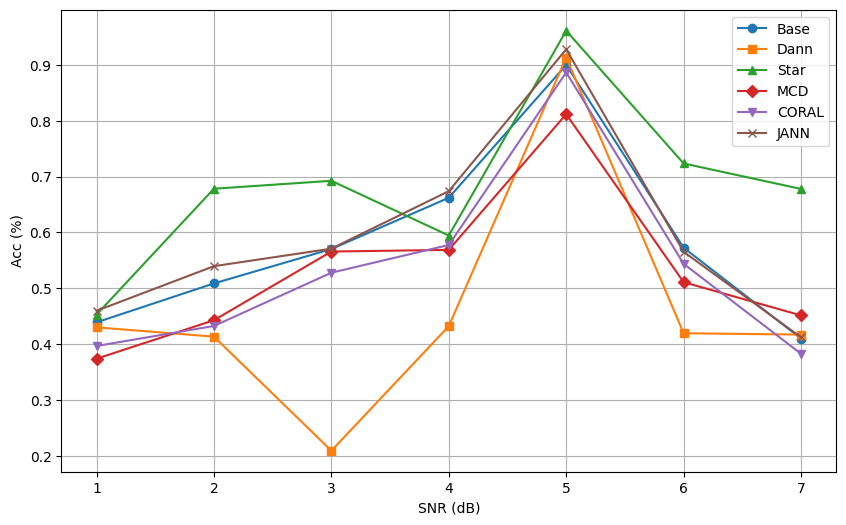

In [3]:
x = np.arange(1, 8)

plt.figure(figsize=(10, 6))
plt.plot(x, base_acc, marker='o', linestyle='-', label='Base')
plt.plot(x, dann_acc, marker='s', linestyle='-', label='Dann')
plt.plot(x, star_acc, marker='^', linestyle='-', label='Star')
plt.plot(x, mcd_acc, marker='D', linestyle='-', label='MCD')
plt.plot(x, coral_acc, marker='v', linestyle='-', label='CORAL')
plt.plot(x, jan_acc, marker='x', linestyle='-', label='JANN')

plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.legend()
plt.grid(True)
plt.show()